In [1]:
# imports
import numpy as np
import pandas as pd
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.models import load_model
from sklearn.metrics import accuracy_score
from matplotlib import pyplot


## Conditional Generative Adversarial Network (CGAN)
Generative adversarial network's architecture is comprised of a *generator* and a *discriminator* model. 
* The generator model is responsible for generating new plausible examples that ideally are indistinguishable from real examples in the dataset. 
* The discriminator model is responsible for classifying a given image as either real (drawn from the dataset) or fake (generated).

## Dataset

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

For simplicity, we will filter the dataset and **keep** only **2 classes**.
* T-shirt(0)
* Pullover (2)

In [2]:
# size of image in Fashin-MNIST dataset
img_shape = (28, 28, 1)

# size of the latent space
latent_dim = 100

# number of epochs
n_epochs = 50

# batch size
n_batch=128

In [3]:
def load_real_samples(classes = [i for i in range(0,10)]):
    '''
    Loads the fashion-minst dataset into memory
    @param classes filters entire set and keeps only indices(labels) of interest. default is 10 classes
    returns X, trainy and number of classes/labels
    '''

    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # keep desired classes
    if len(classes) != 10:
      slice_ = [idx for idx, val in enumerate(trainy) if val in classes]
      trainX = np.asarray([val for idx, val in enumerate(trainX) if idx in slice_])
      trainy = np.asarray([val for idx, val in enumerate(trainy) if idx in slice_])
      # NOTE TO SELF: dirty solution
      trainy = np.asarray([1 if x==2 else x for x in trainy])

    # expand to 3d, e.g. add channels
    X = np.expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    # find nr of classes
    nr_classes = len(np.unique(trainy))
    return [X, trainy], nr_classes

In [4]:
def build_discriminator(n_classes, in_shape=img_shape):
  '''
  Defines the standalone discriminator model. Adds an extra Embedding layer at the input
  It takes an integer for the class label of the image. This has the effect of making the input image conditional on the provided class label.
  The class label is then passed through an Embedding layer with the size of 50. This means that each of the 10 classes for the Fashion MNIST dataset (0 through 9) 
  will map to a different 50-element vector representation that will be learned by the discriminator model.
  returns the model
  '''
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # scale up to image dimensions with linear activation
  n_nodes = in_shape[0] * in_shape[1]
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)
  # image input
  in_image = Input(shape=in_shape)
  # concat label as a channel
  merge = Concatenate()([in_image, li])
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # dropout
  fe = Dropout(0.4)(fe)
  # output
  out_layer = Dense(1, activation='sigmoid')(fe)
  # define model
  discriminator = Model([in_image, in_label], out_layer)
  # compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return discriminator

In [5]:
def build_generator(latent_dim, n_classes):
  '''
  Defines the standalone generator model. Adds an extra Embedding layer at the input
  It takes an integer for the class label of the image. This has the effect of making the input image conditional on the provided class label.
  The class label is then passed through an Embedding layer with the size of 50. This means that each of the 10 classes for the Fashion MNIST dataset (0 through 9) 
  will map to a different 50-element vector representation that will be learned by the discriminator model.
  returns the model
  '''
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes = 7 * 7
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((7, 7, 1))(li)
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((7, 7, 128))(gen)
  # merge image gen and label input
  merge = Concatenate()([gen, li])
  # upsample to 14x14
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 28x28
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # output
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
  # define model
  generator = Model([in_lat, in_label], out_layer)
  return generator

In [6]:
# define the combined generator and discriminator model, for updating the generator
def build_c_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [7]:
# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = np.ones((n_samples, 1))
	return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples, n_classes):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples, n_classes)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

## Loss Function

The standard MinMax loss function of GAN is the following. The generator tries to minimize the function while the discrimitator to maximize it.

\begin{equation*}
\mathbb{E}_{x}[logD(x|y)] + \mathbb{E}_{z}[log(1-D(G(z|y)))
\end{equation*}


* D(x) is the discriminator's estimate of the probability that real data instance x is real.
* Ex is the expected value over all real data instances.
* G(z) is the generator's output when given noise z.
* D(G(z)) is the discriminator's estimate of the probability that a fake instance is real.
* Ez is the expected value over all random inputs to the generator (in effect, the expected value over all generated fake instances G(z)).
* The formula derives from the cross-entropy between the real and generated distributions.

Conditional GANs modifies standard loss. This version of GAN is used to learn a multimodal model. It basically generates descriptive labels which are the attributes associated with the particular image that was not part of the original training data. 

CGANs are mainly employed in image labelling, where both the generator and the discriminator are fed with some extra information y which works as an auxiliary information, such as class labels from or data associated with different modalities. 

The conditioning is usually done by feeding the information y into both the discriminator and the generator, as an additional input layer to it.  The only difference between them is that a conditional probability is used for both the generator and the discriminator, instead of the regular one.

\begin{equation*}
\min_{G} \min_{D}V(D,G) = \mathbb{E}_{x _{\tilde{}} p_{data}}(x)[logD(x|y)] + \mathbb{E}_{z _{\tilde{}} p_{z}}(z)[log(1-D(G(z|y)))]
\end{equation*}


## Load FashionMinst Dataset

In [8]:
# load image data, filter dataset by desired classes, T-shirt/top (0) and Pullover (2)
dataset, nr_classes = load_real_samples(classes=[0,2])

4431872/4422102 [==============================] - 0s 0us/step


## Train Model

In [9]:
# train the generator and discriminator
model_history_dict = {}
def train(g_model, d_model, gan_model, dataset, latent_dim, n_classes, n_epochs=1, n_batch=128):
  batch_per_epoch = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # keep track of losses and accuracy
    disc_loss = 0.0
    gen_loss = 0.0
    acc = 0.0
    # enumerate batches over the training set
    for j in range(batch_per_epoch):
      # get randomly selected 'real' samples
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss_real = d_model.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch, n_classes)
      # update discriminator model weights
      d_loss_fake = d_model.train_on_batch([X_fake, labels], y_fake)
      # compute discriminator loss
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch, n_classes)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      print(f'epoch={i+1}, {j+1}/{batch_per_epoch}, d_loss={d_loss[0]}, g_loss={g_loss}, accuracy={100*d_loss[1]}')
      disc_loss += d_loss[0]
      gen_loss += g_loss
      acc += 100 * d_loss[1]
    
    model_history_dict[i] = {
        'd_loss' : disc_loss / batch_per_epoch,
        'g_loss' : gen_loss / batch_per_epoch,
        'accuracy': acc / batch_per_epoch
    }

  # save the generator model
  g_model.save('cgan_generator.h5')


In [10]:
# create the discriminator
d_model = build_discriminator(n_classes=nr_classes, in_shape=img_shape)
# create the generator
g_model = build_generator(latent_dim, n_classes=nr_classes)
# # create the c-gan
c_gan_model = build_c_gan(g_model, d_model)
# train model
train(g_model, d_model, c_gan_model, dataset, latent_dim, nr_classes, n_epochs=n_epochs, n_batch=n_batch)

epoch=1, 1/93, d_loss=0.6929148137569427, g_loss=0.6909366846084595, accuracy=30.46875
epoch=1, 2/93, d_loss=0.6611411869525909, g_loss=0.6879632472991943, accuracy=48.4375
epoch=1, 3/93, d_loss=0.6289168894290924, g_loss=0.6832457780838013, accuracy=50.0
epoch=1, 4/93, d_loss=0.6076144278049469, g_loss=0.6764098405838013, accuracy=50.0
epoch=1, 5/93, d_loss=0.5796568393707275, g_loss=0.6699592471122742, accuracy=50.0
epoch=1, 6/93, d_loss=0.5717148035764694, g_loss=0.6668551564216614, accuracy=50.0
epoch=1, 7/93, d_loss=0.546980008482933, g_loss=0.6781892776489258, accuracy=50.0
epoch=1, 8/93, d_loss=0.5098751187324524, g_loss=0.7072199583053589, accuracy=57.8125
epoch=1, 9/93, d_loss=0.4752596318721771, g_loss=0.7460548877716064, accuracy=96.09375
epoch=1, 10/93, d_loss=0.44084442406892776, g_loss=0.7670813798904419, accuracy=100.0
epoch=1, 11/93, d_loss=0.42589574307203293, g_loss=0.7614137530326843, accuracy=100.0
epoch=1, 12/93, d_loss=0.41974297910928726, g_loss=0.732200443744659

## Plot Accuracy and Losses history

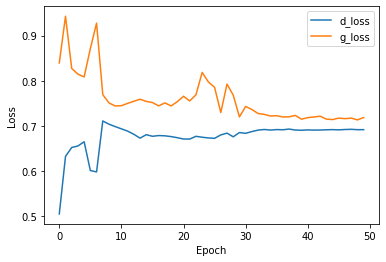

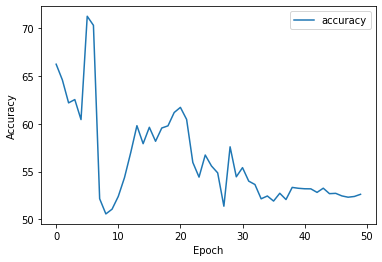

In [11]:
def plot_metrics(D):
  '''
  Converts dict into pandas dataframe and plots columns['d_loss', 'g_loss', 'accuracy'] per epoch
  '''
  df_h = pd.DataFrame.from_dict(D, orient='index')
  df_h.plot(y=["d_loss", "g_loss"], kind="line", xlabel='Epoch', ylabel='Loss')
  df_h.plot(y=["accuracy"], kind="line", xlabel='Epoch', ylabel='Accuracy')

plot_metrics(model_history_dict)

## Plot image of both classes

class T-shirt, Pullover


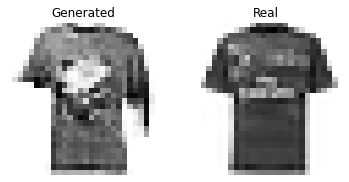

In [140]:
def real_random_image(dataset, target_class):
  images, labels = dataset
  idx = np.random.choice(np.asarray(np.where(labels == target_class)).flat) 
  return images[idx]

def generate_latent_points_by_class(latent_dim, n_samples, target_class):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = np.empty(n_samples)
  labels.fill(target_class)
  
  return [z_input, labels]

# create and show plot of generated image and real one
def show_images(generated, target_class):
  # plot generated image
  pyplot.subplot(1, 2, 1)
  pyplot.axis('off')
  pyplot.title('Generated')
  pyplot.imshow(generated[0, :, :, 0], cmap='gray_r')

  # plot random image of target_class from original dataset
  real = real_random_image(dataset, target_class)
  pyplot.subplot(1, 2, 2)
  pyplot.axis('off')
  pyplot.title('Real')
  pyplot.imshow(real[:, :, 0], cmap='gray_r')
  # show plot
  pyplot.show()


# load model
model = load_model('cgan_generator.h5')
nr_of_samples = 1
for index, label in enumerate(['T-shirt, Pullover']):
  print(f'class {label}')
  target_class = index
  # generate images
  latent_points, labels = generate_latent_points_by_class(latent_dim, nr_of_samples, target_class)

  # generate images
  X  = model.predict([latent_points, labels])

  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot the result
  show_images(X, target_class)



## Predict on real and fake images

We will generate 1K images from the Generator and 1K from real dataset(uniform) and will check the accuracy of the model.

In [15]:
# sample real images from dataset
[X_real, labels_real], y_real = generate_real_samples(dataset, 1000)
# generate fake images using generator model
[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, 1000, nr_classes)

# concatenate both real and fake samples into one dataset
X = np.concatenate((X_real, X_fake), axis=0)
y_true = np.concatenate((labels_real, labels_fake), axis=0)

# use the discrimator model to predict
y_pred = d_model.predict([X, y_true])
y_pred = np.argmax(y_pred, axis=1)

acc_score = accuracy_score(y_true, y_pred)
print(f'accuracy on new dataset is {acc_score}')

accuracy on new dataset is 0.51
